<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Foundations of Data Science
</font>
<hr/>
<font color="#800080" size=5>
Phase 1 Report: Research Assistant
<br>
</font>
<font size=5>
Instructor: Dr. Khalaj
<br>
</font>
<font size=4>
Fall 2024
<br>
<font face="Times New Roman" size=4>
Ali Sadeghiyan 400101464
</font>

</div></font>

# Libraries:

In [1]:
# Step 1: Install Kaggle API and authenticate using the Kaggle CLI
!pip install -q kaggle

# Step 2: Use the Kaggle API to download the dataset
!kaggle datasets download -d nechbamohammed/research-papers-dataset -p /content

# Step 3: Unzip the downloaded file
!unzip /content/research-papers-dataset.zip -d /content

# List files to verify the extraction
!ls /content

# !pip install -U langchain-community psycopg2-binary transformers keybert spacy tabulate
# !pip install keybert
# !pip install -U langchain-community

# !pip uninstall -y community
# !pip install python-louvain

Dataset URL: https://www.kaggle.com/datasets/nechbamohammed/research-papers-dataset
License(s): unknown
 98% 579M/590M [00:07<00:00, 105MB/s]
100% 590M/590M [00:07<00:00, 77.5MB/s]
Archive:  /content/research-papers-dataset.zip
  inflating: /content/dblp-v10.csv   
dblp-v10.csv  research-papers-dataset.zip  sample_data


In [2]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
import nltk
from scipy.stats import pearsonr, spearmanr
from collections import Counter
import ast
from tabulate import tabulate
import networkx as nx
import os
import spacy
from langchain.vectorstores import FAISS
from langchain.embeddings.base import Embeddings
from langchain.docstore.document import Document
import random
from collections import defaultdict
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import jaccard_score
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from transformers import BertTokenizer, BertModel
import json
import ast
from keybert import KeyBERT
from itertools import combinations
from scipy.cluster.hierarchy import linkage, fcluster
from community import community_louvain
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import  squareform

# 1 EDA:

In [3]:
# Load the dataset
file_path = "dblp-v10.csv"

## 1.1 Basic:

### 1. Number of Publications Over Year Ranges

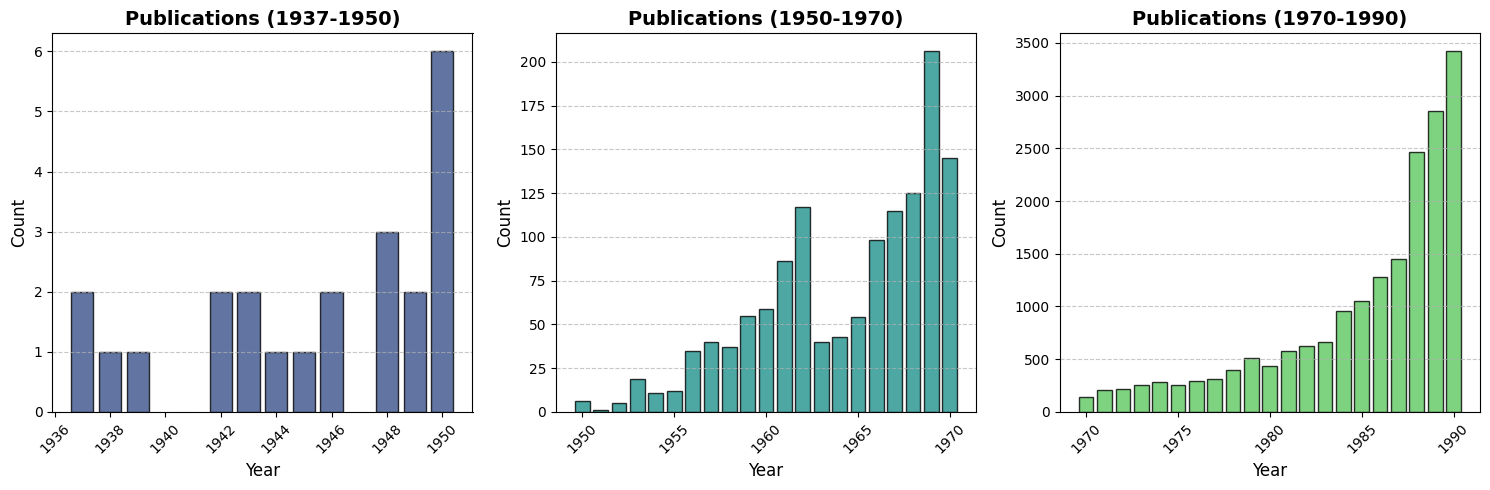

In [ ]:
# Load data
df = pd.read_csv(file_path, usecols=["year"])
df = df[df["year"] > 1900]  # Filter out invalid years

# Define year ranges
year_ranges = [(1937, 1950), (1950, 1970), (1970, 1990)]
colors = sns.color_palette("viridis", len(year_ranges))  # Use a different color for each plot

plt.figure(figsize=(15, 5))
for i, (start, end) in enumerate(year_ranges):
    plt.subplot(1, 3, i + 1)
    yearly_counts = df[(df["year"] >= start) & (df["year"] <= end)]["year"].value_counts().sort_index()

    plt.bar(yearly_counts.index, yearly_counts.values, color=colors[i], edgecolor="black", alpha=0.8)
    plt.title(f"Publications ({start}-{end})", fontsize=14, fontweight="bold")
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


### 2. Number of References Over Years



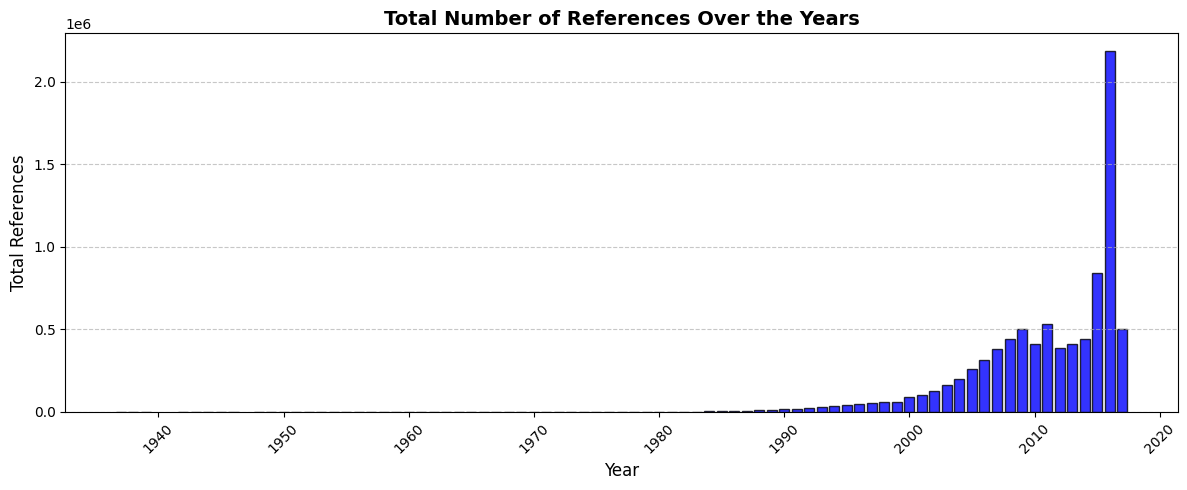

In [ ]:
# Load data
df = pd.read_csv(file_path, usecols=["year", "references"])

# Convert 'references' column to a count of references per entry
df["references"] = df["references"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.startswith("[") else 0)

# Aggregate total references per year
yearly_references = df.groupby("year")["references"].sum()

# Plot
plt.figure(figsize=(12, 5))
plt.bar(yearly_references.index, yearly_references.values, color="blue", edgecolor="black", alpha=0.8)
# Formatting
plt.title("Total Number of References Over the Years", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total References", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

### 3. Number of Authors Over Years

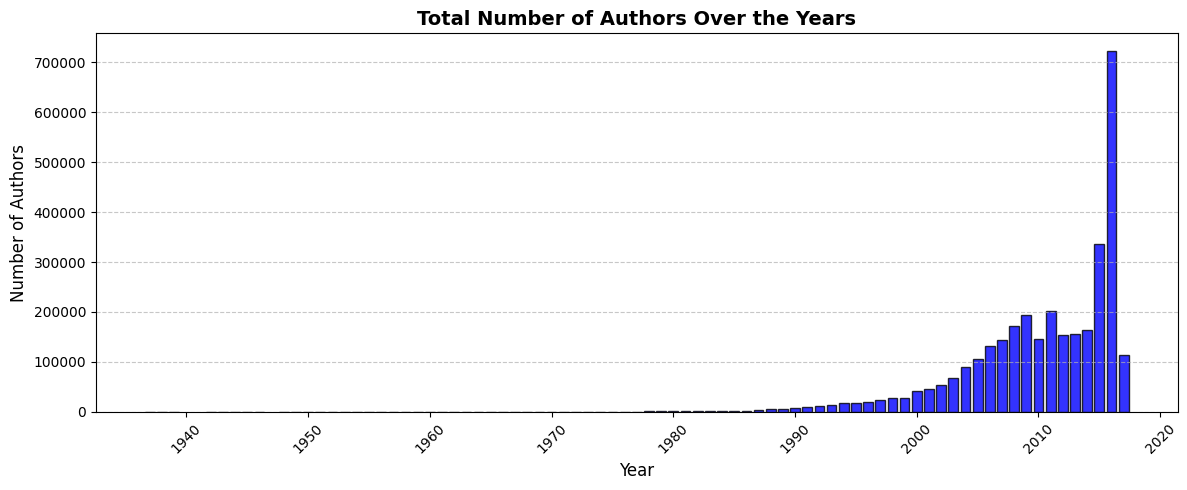

In [ ]:
# Load data
df = pd.read_csv(file_path, usecols=["year", "authors"])

# Convert 'authors' column to count the number of authors per entry
df["authors"] = df["authors"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.startswith("[") else 1)

# Aggregate total authors per year
yearly_authors = df.groupby("year")["authors"].sum()

# Plot
plt.figure(figsize=(12, 5))
plt.bar(yearly_authors.index, yearly_authors.values, color="blue", edgecolor="black", alpha=0.8)

# Formatting
plt.title("Total Number of Authors Over the Years", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Authors", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


### 4. Pearson & Spearman Correlation - Authors vs References

In [ ]:
# Load data
df = pd.read_csv(file_path, usecols=["authors", "references"])

# Convert 'authors' column to count the number of authors per entry
df["authors"] = df["authors"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.startswith("[") else 1)

# Convert 'references' column to count the number of references per entry
df["references"] = df["references"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.startswith("[") else 0)

# Compute Pearson and Spearman correlations
pearson_authors_refs, _ = pearsonr(df["authors"], df["references"])
spearman_authors_refs, _ = spearmanr(df["authors"], df["references"])

# Print results
print(f"Pearson Authors-References: {pearson_authors_refs:.4f}")
print(f"Spearman Authors-References: {spearman_authors_refs:.4f}")

Pearson Authors-References: 0.0560
Spearman Authors-References: 0.0872


### 5. Pearson & Spearman Correlation - Authors vs Citations

In [ ]:
# Load data
df_corr2 = pd.read_csv(file_path, usecols=["authors", "n_citation"])

# Convert 'authors' column to count the number of authors per entry
df_corr2["authors"] = df_corr2["authors"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.startswith("[") else 1)

# Compute Pearson and Spearman correlations
pearson_authors_citations, _ = pearsonr(df_corr2["authors"], df_corr2["n_citation"])
spearman_authors_citations, _ = spearmanr(df_corr2["authors"], df_corr2["n_citation"])

# Print results
print(f"Pearson Authors-Citations: {pearson_authors_citations:.4f}")
print(f"Spearman Authors-Citations: {spearman_authors_citations:.4f}")


Pearson Authors-Citations: -0.0028
Spearman Authors-Citations: -0.0166


### 6. Bar Chart of Title Length Over the Years

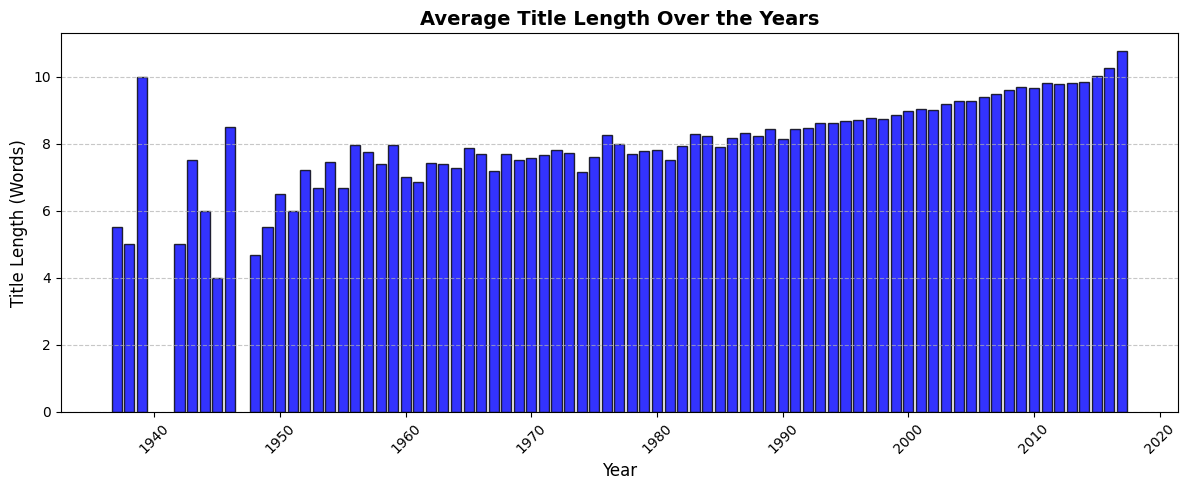

In [ ]:
# Load data
df_titles = pd.read_csv(file_path, usecols=["year", "title"])

# Compute title length (word count per title)
df_titles["title_length"] = df_titles["title"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Aggregate average title length per year
yearly_title_length = df_titles.groupby("year")["title_length"].mean()

# Plot
plt.figure(figsize=(12, 5))
plt.bar(yearly_title_length.index, yearly_title_length.values, color="blue" , edgecolor="black", alpha=0.8)

# Formatting
plt.title("Average Title Length Over the Years", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Title Length (Words)", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


### 7. Wordcloud of Abstracts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


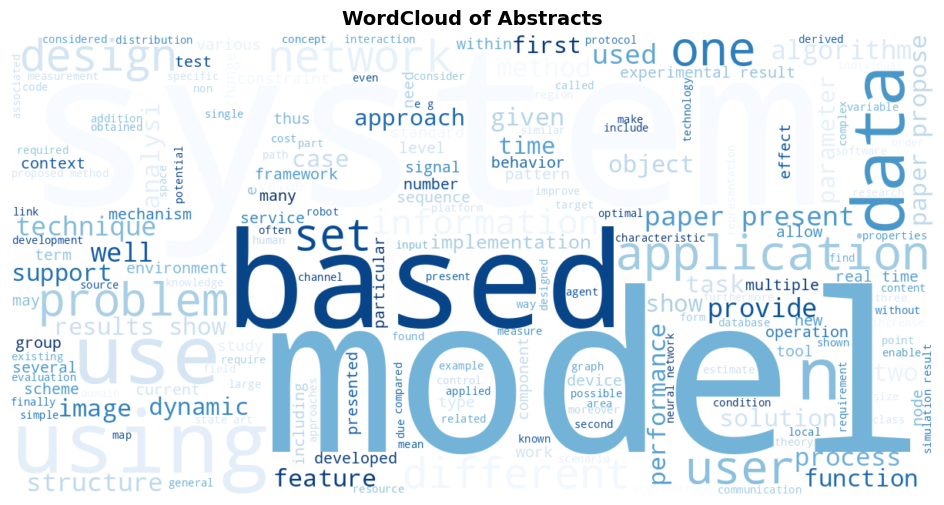

In [ ]:
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download stopwords if not already downloaded
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Load the dataset with a robust encoding strategy
file_path = "dblp-v10.csv"  # Update this path accordingly

# Try different encodings if needed
try:
    df = pd.read_csv(file_path, usecols=["abstract"], encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, usecols=["abstract"], encoding="ISO-8859-1")

# Drop missing abstracts
df = df.dropna()

# Sample a fraction of the data for efficiency
df = df.sample(frac=0.05, random_state=42)

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.encode("ascii", "ignore").decode()  # Remove non-ASCII characters
    text = re.sub(r'[:,/]', ' ', text)  # Explicitly remove commas, colons, and slashes
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

# Clean all abstracts
df["cleaned_abstract"] = df["abstract"].apply(clean_text)

# Combine all abstracts into a single string
all_text = " ".join(df["cleaned_abstract"])

# Generate word cloud with blue color theme
wordcloud = WordCloud(width=1200, height=600, background_color="white", colormap="Blues").generate(all_text)

# Plot word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Abstracts", fontsize=14, fontweight="bold")
plt.show()

### 8. Correlation Title Length vs Referenced Title Length


Pearson Correlation: 0.1000
Spearman Correlation: 0.1478


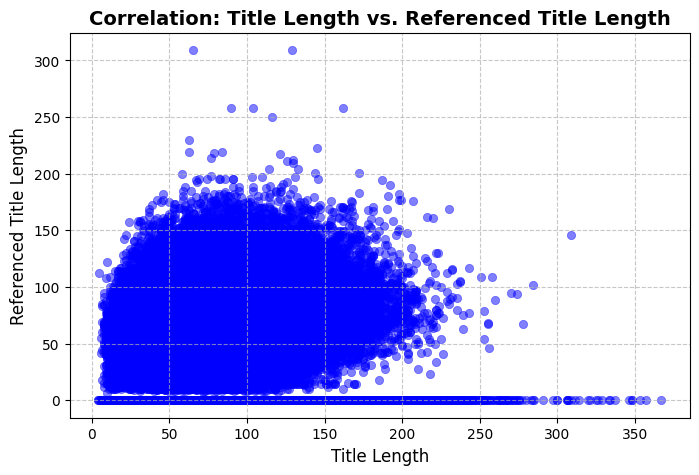

In [ ]:
# Load only 'id', 'title', and 'references' columns
df = pd.read_csv(file_path, usecols=["id", "title", "references"])

# Compute title length
df["title_length"] = df["title"].apply(lambda x: len(str(x)))

# Convert 'references' column from string to list
df["references"] = df["references"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else [])

# Create a dictionary for quick lookup of title lengths by paper ID
title_length_dict = df.set_index("id")["title_length"].to_dict()

# Function to compute average referenced title length
def avg_referenced_title_length(ref_list):
    ref_lengths = [title_length_dict[ref] for ref in ref_list if ref in title_length_dict]
    return sum(ref_lengths) / len(ref_lengths) if ref_lengths else 0

# Compute the average title length of referenced papers
df["referenced_title_length"] = df["references"].apply(avg_referenced_title_length)

# Drop rows with missing values (if any)
df.dropna(subset=["title_length", "referenced_title_length"], inplace=True)

# Compute Pearson & Spearman correlation coefficients
pearson_corr, _ = pearsonr(df["title_length"], df["referenced_title_length"])
spearman_corr, _ = spearmanr(df["title_length"], df["referenced_title_length"])

# Display results
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

# Scatter plot visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="title_length", y="referenced_title_length", color="blue", alpha=0.5, edgecolor=None)
plt.xlabel("Title Length", fontsize=12)
plt.ylabel("Referenced Title Length", fontsize=12)
plt.title("Correlation: Title Length vs. Referenced Title Length", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()


### 9. Top 10 Authors with Most Publications



Top 10 Authors by Publications:
Wei Wang       950
Wei Zhang      657
Yang Liu       629
Lei Zhang      579
Wei Li         559
Jun Wang       544
Lei Wang       519
Lajos Hanzo    458
Wei Liu        456
Jun Zhang      455
Name: count, dtype: int64


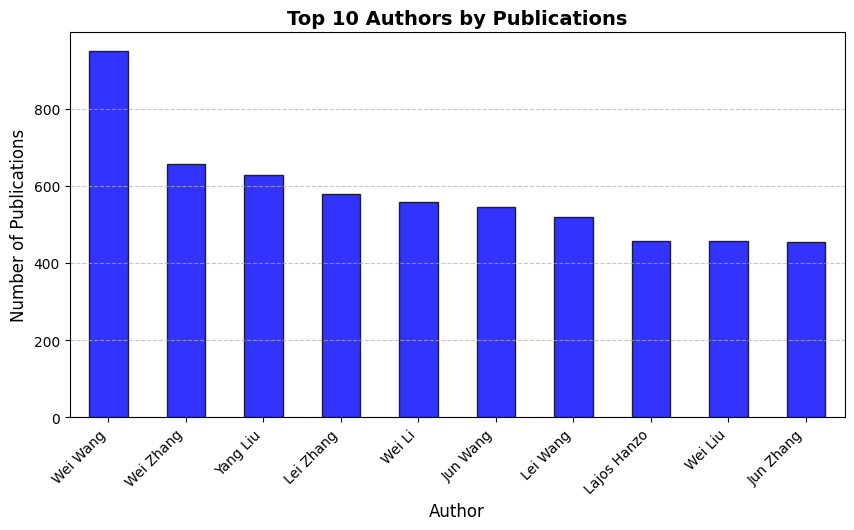

In [ ]:
df = pd.read_csv(file_path, usecols=["authors"])

# Convert string to list
df["authors"] = df["authors"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else [])

# Count publications per author
author_counts = pd.Series([author for authors in df["authors"] for author in authors]).value_counts()

# Print top 10 authors
print("\nTop 10 Authors by Publications:")
print(author_counts.head(10))

# Plot
plt.figure(figsize=(10, 5))
author_counts.head(10).plot(kind="bar", color="blue", edgecolor="black", alpha=0.8)
plt.title("Top 10 Authors by Publications", fontsize=14, fontweight="bold")
plt.xlabel("Author", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


### 10. Top 10 Authors with Most Citations



Top 10 Authors by Citations:
David G. Lowe        65344
Hari Balakrishnan    55096
Scott Shenker        54164
Ian F. Akyildiz      53654
Michael I. Jordan    53448
Ion Stoica           52890
Chih-Jen Lin         52302
Takeo Kanade         50743
Deborah Estrin       49925
Vladimir Vapnik      49755
dtype: int64


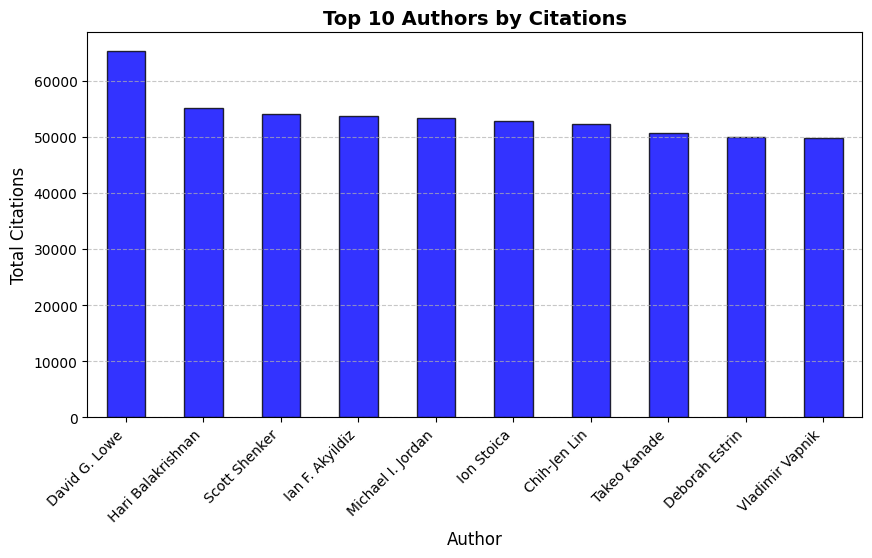

In [ ]:
# Load authors and citations data
df = pd.read_csv(file_path, usecols=["authors", "n_citation"])

# Convert string to list
df["authors"] = df["authors"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else [])

# Aggregate total citations per author
author_citations = {}

for _, row in df.iterrows():
    for author in row["authors"]:
        author_citations[author] = author_citations.get(author, 0) + row["n_citation"]

# Convert to Series and sort
top_cited_authors = pd.Series(author_citations).sort_values(ascending=False)

# Print top 10 cited authors
print("\nTop 10 Authors by Citations:")
print(top_cited_authors.head(10))

# Plot
plt.figure(figsize=(10, 5))
top_cited_authors.head(10).plot(kind="bar", color="blue", edgecolor="black", alpha=0.8)
plt.title("Top 10 Authors by Citations", fontsize=14, fontweight="bold")
plt.xlabel("Author", fontsize=12)
plt.ylabel("Total Citations", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


### 11. Top 10 Papers with Most References


Top 10 Papers by References:
                                          id  num_references
371369  c6090c87-4730-4ae6-86cd-7663adb23b2b             759
780292  a1c66cbc-77ad-4167-9787-4936221427ad             561
104143  6d4c5b32-8e13-4022-b67f-1ace7ffc91d0             412
214646  91f1068b-9feb-4799-b920-67205c36999b             396
484969  ebe93176-7150-4ce6-8d77-880a4e13beb0             394
223901  95044198-6db4-4224-a499-d8e8a3e1f52d             386
302124  af0e7b77-e5c3-4d64-adc2-cc43a4b0976e             363
707510  0d3b901e-4179-4ed6-badf-7ce4237dadd4             361
325083  b6b998ee-2e78-4d0e-8c55-e7806e449b9e             343
538381  fdbb0c65-8b80-43e7-a839-8738e03cd72e             326


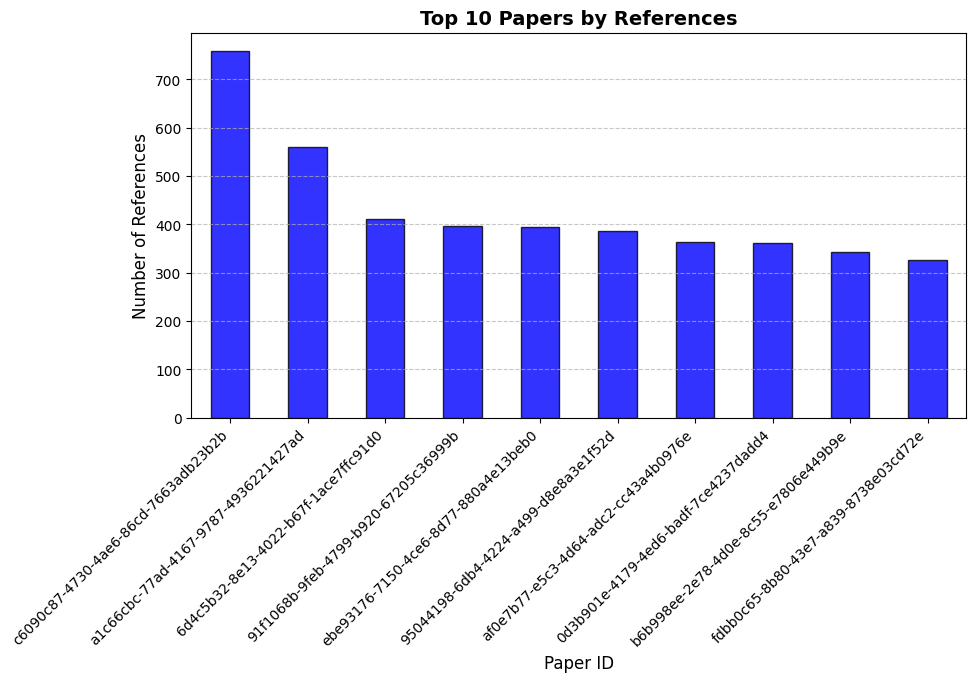

In [ ]:
# Load paper references data
df = pd.read_csv(file_path, usecols=["id", "references"])

# Count references per paper
df["num_references"] = df["references"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.startswith("[") else 0)

# Print top 10 papers with the most references
print("\nTop 10 Papers by References:")
print(df.nlargest(10, "num_references")[["id", "num_references"]])

# Plot
plt.figure(figsize=(10, 5))
df.nlargest(10, "num_references").set_index("id")["num_references"].plot(kind="bar", color="blue", edgecolor="black", alpha=0.8)
plt.title("Top 10 Papers by References", fontsize=14, fontweight="bold")
plt.xlabel("Paper ID", fontsize=12)
plt.ylabel("Number of References", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


### 12. Find the top 10 papers with the most citations within the dataset.


Top 10 Papers by Citations:
        n_citation                                    id
332760       42508  b944f77f-113b-4a02-ae5e-d4a124b8fd5b
294527       34288  ac744614-9003-4ccb-93bf-2fe5b1ef4166
358174       33016  c1b6b493-01ef-420f-be44-7bacfe34e846
716671       28679  f6bd8b64-684d-429a-aab5-8ff3a2c23cd6
18485        26114  50dd56db-151d-4d62-8576-65f0ef6f381b
45248        24381  59af7e25-c0ee-4af5-acea-a58dfe4ccac4
81801        24245  65d5ccdc-7022-45b0-adf9-0385273b1283
150727       24182  7ccbdf09-a84e-4ad2-ab20-cb28b6c41155
458466       22884  e2f7a74a-8430-4463-94ce-fe85dfd309f9
442067       22795  dd83785a-dd19-41e3-9b25-ebabbd48d336


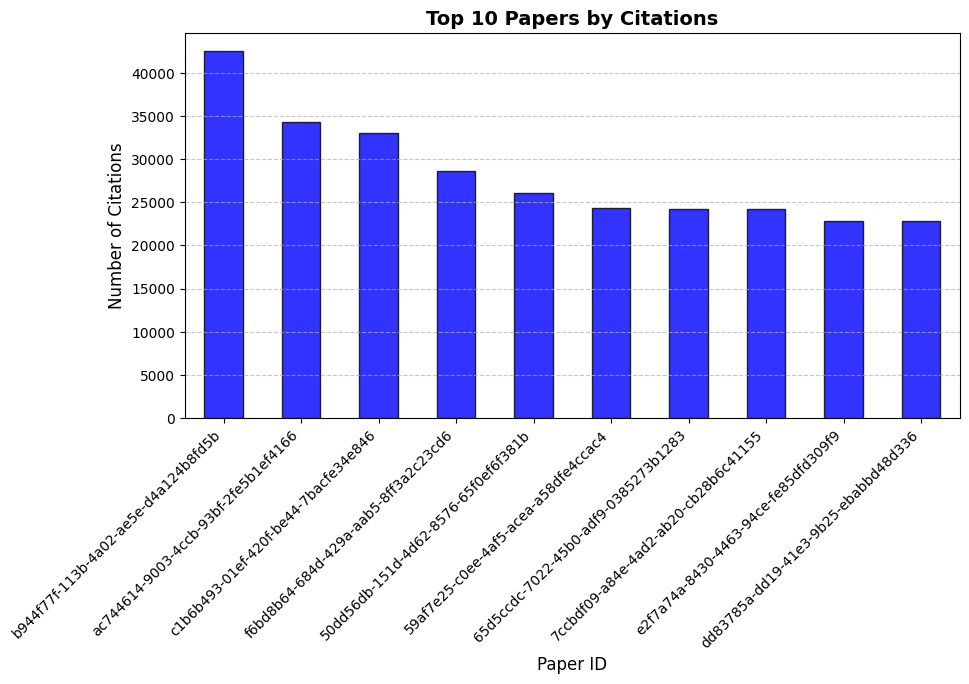

In [ ]:
# Load dataset
df = pd.read_csv(file_path, usecols=["id", "n_citation"])

# Get top 10 papers by citation count
top_cited_papers = df.nlargest(10, "n_citation")

# Print results
print("\nTop 10 Papers by Citations:")
print(top_cited_papers)

# Plot
plt.figure(figsize=(10, 5))
top_cited_papers.set_index("id")["n_citation"].plot(kind="bar", color="blue", edgecolor="black", alpha=0.8)
plt.title("Top 10 Papers by Citations", fontsize=14, fontweight="bold")
plt.xlabel("Paper ID", fontsize=12)
plt.ylabel("Number of Citations", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


### 13. Predicting Citations Based on Publications (Linear Regression)

R² Score: 0.3387
(Closer to 1 means strong prediction, closer to 0 means weak prediction)


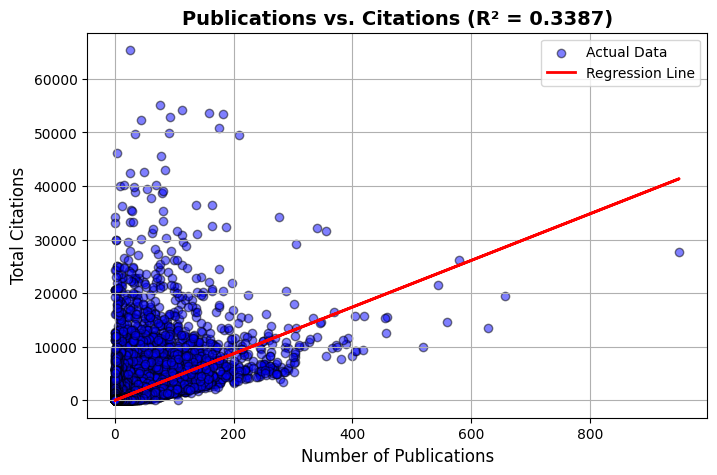

In [ ]:
# Load dataset
df = pd.read_csv(file_path, usecols=["authors", "n_citation"]).dropna()

# Convert authors from string to list
df["authors"] = df["authors"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Count publications per author
author_publications = Counter(author for authors in df["authors"] for author in authors)

# Compute total citations per author
author_citations = Counter()
for _, row in df.iterrows():
    for author in row["authors"]:
        author_citations[author] += row["n_citation"]

# Create DataFrame
author_stats = pd.DataFrame({
    "Author": list(author_publications.keys()),
    "Publications": list(author_publications.values()),
    "Total Citations": [author_citations[author] for author in author_publications.keys()]
})

# Prepare data for regression
X = np.array(author_stats["Publications"]).reshape(-1, 1)
y = np.array(author_stats["Total Citations"])

# Train Linear Regression Model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Compute R² Score
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")
print("(Closer to 1 means strong prediction, closer to 0 means weak prediction)")

# Scatter Plot & Regression Line
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.5, label="Actual Data", color="blue", edgecolor="black")
plt.plot(X, y_pred, color="red", linewidth=2, label="Regression Line")
plt.xlabel("Number of Publications", fontsize=12)
plt.ylabel("Total Citations", fontsize=12)
plt.title(f"Publications vs. Citations (R² = {r2:.4f})", fontsize=14, fontweight="bold")
plt.legend()
plt.grid()

plt.show()

## 1.2 Network Analysis:

### 1.2.1 Citation Network (Paper-Paper Network):

#### What We've Done:

1. **Constructed the Citation Network**  
   - Loaded paper IDs and their citation references.
   - Created a directed graph where nodes represent papers, and edges represent citations.

2. **Analyzed Clustering Coefficient Over Time**  
   - Computed the clustering coefficient for each paper.
   - Aggregated the data by year and visualized the trend using a line plot.

3. **Measured Network Reachability**  
   - Extracted the largest strongly connected component.
   - Calculated the average shortest path length and diameter to measure network reachability.

4. **Identified Influential Papers Using PageRank**  
   - Computed PageRank scores for all papers.
   - Extracted and visualized the top 10 most influential papers.


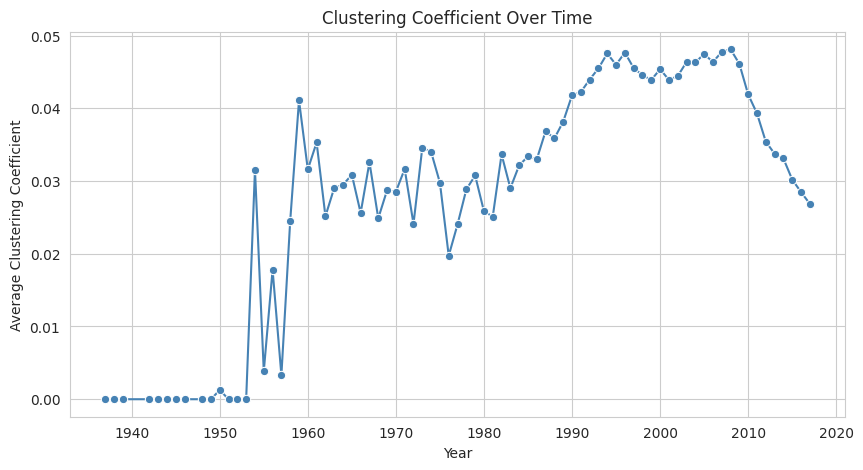

Average Path Length: 11.288044063779358
Diameter: 29
Top 10 Influential Papers (by PageRank):
Paper ID: 6a6b9aa6-683f-4c7c-b06e-9c3018d10fd3, PageRank Score: 0.000223
Paper ID: c1b6b493-01ef-420f-be44-7bacfe34e846, PageRank Score: 0.000191
Paper ID: b944f77f-113b-4a02-ae5e-d4a124b8fd5b, PageRank Score: 0.000180
Paper ID: f6bd8b64-684d-429a-aab5-8ff3a2c23cd6, PageRank Score: 0.000138
Paper ID: 2659531e-eb9d-4dd5-b46f-10f66a4819c6, PageRank Score: 0.000116
Paper ID: 748a2ab3-8b5f-4d0a-9e2d-af685089843a, PageRank Score: 0.000106
Paper ID: e0f3a738-4ab2-40d1-ba44-506d81c1d230, PageRank Score: 0.000097
Paper ID: 8026f56a-a93e-4933-8ead-c9aa9e3f0498, PageRank Score: 0.000094
Paper ID: 7ccbdf09-a84e-4ad2-ab20-cb28b6c41155, PageRank Score: 0.000093
Paper ID: d3e00e7e-1c64-4d7a-b2b2-1ad98ba4c706, PageRank Score: 0.000093


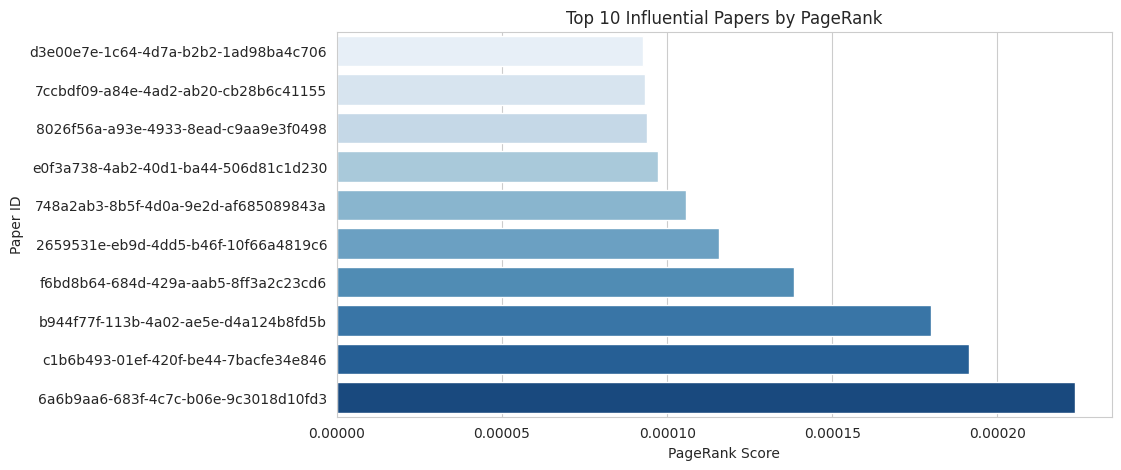

In [ ]:
# Set theme and color palette
sns.set_style("whitegrid")
sns.set_palette("Blues")  # Ensure plots maintain a blue color theme

# Load only the necessary columns: 'id' and 'references' to construct the citation network
df_citations = pd.read_csv(file_path, usecols=["id", "references", "year"])

# Convert 'references' from string to list safely
df_citations["references"] = df_citations["references"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else []
)

# Create a directed graph for the citation network
G = nx.DiGraph()

# Add paper nodes
G.add_nodes_from(df_citations["id"])

# Add citation edges
edges = [
    (paper_id, ref_id)
    for paper_id, refs in zip(df_citations["id"], df_citations["references"])
    for ref_id in refs
]
G.add_edges_from(edges)

# 1. Clustering Coefficient Analysis Over Time
# Compute clustering coefficient for each node (paper)
df_citations["clustering_coefficient"] = df_citations["id"].apply(
    lambda x: nx.clustering(G, x) if x in G else 0
)

# Calculate the average clustering coefficient per year
clustering_by_year = df_citations.groupby("year")["clustering_coefficient"].mean()

# Plot Clustering Coefficient Over Time
plt.figure(figsize=(10, 5))
sns.lineplot(x=clustering_by_year.index, y=clustering_by_year.values, marker="o", color="steelblue")
plt.xlabel("Year")
plt.ylabel("Average Clustering Coefficient")
plt.title("Clustering Coefficient Over Time")
plt.show()

# 2. Network Reachability: Average Path Length and Diameter
# Extract the largest strongly connected component for meaningful analysis
largest_component = max(nx.strongly_connected_components(G), key=len)
G_sub = G.subgraph(largest_component)  # Subgraph containing the largest component

# Compute average shortest path length and diameter, handling potential errors
try:
    avg_path_length = nx.average_shortest_path_length(G_sub)
    diameter = nx.diameter(G_sub)
except nx.NetworkXError:
    avg_path_length, diameter = np.nan, np.nan  # Assign NaN if graph is disconnected

print(f"Average Path Length: {avg_path_length}")
print(f"Diameter: {diameter}")

# 3. Identifying Influential Papers Using PageRank
pagerank_scores = nx.pagerank(G)

# Extract top 10 most influential papers based on PageRank score
top_10_papers = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Influential Papers (by PageRank):")
for paper, score in top_10_papers:
    print(f"Paper ID: {paper}, PageRank Score: {score:.6f}")

# Bar Chart Visualization for Top 10 Influential Papers
plt.figure(figsize=(10, 5))
sns.barplot(x=[p[1] for p in top_10_papers],y=[p[0] for p in top_10_papers],palette="Blues_r")  # Reverse blues color palette
plt.xlabel("PageRank Score")
plt.ylabel("Paper ID")
plt.title("Top 10 Influential Papers by PageRank")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


### 1.2.2 Co-authorship Network (Author-Author Network):

#### **What We've Done:**  

1. **Built the Co-Authorship Network**  
  - Loaded and preprocessed author and year data.  
  - Created an **undirected graph** where nodes represent authors and edges represent co-authorship relationships.  

2. **Analyzed Network Density Over Time**  
  - Calculated network density for each year to observe collaboration trends.  
  - Plotted a **line graph** showing how co-authorship density evolved over time.  

3.  **Identified Influential Researchers**  
  - Computed **degree centrality** (how well-connected an author is).  
  - Computed **betweenness centrality** (how often an author bridges different parts of the network).  
  - Computed **closeness centrality** (how easily an author can reach others in the network).  
  - Extracted **top 10 influential authors** based on these metrics and visualized **degree centrality** using a bar chart.  

4.  **Detected Author Communities**  
  - Used the **Louvain algorithm** to find groups of authors who collaborate frequently.  
  - Identified the **top 5 largest communities** and displayed their sizes.  
  - Plotted a **histogram** to show the distribution of community sizes.  



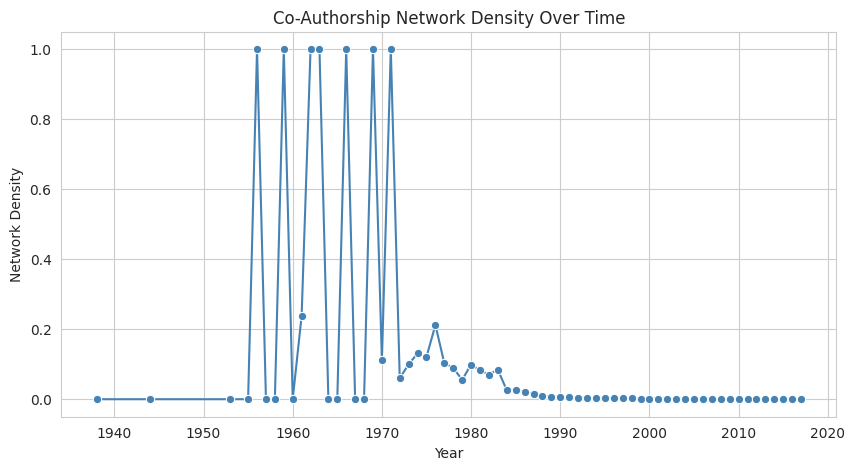

Top 10 Authors by Degree Centrality: ['Zhen Zhang', 'Henning Hermjakob', 'S. Avino', 'F. Acernese', 'P. Amico', 'M. Alshourbagy', 'S. Aoudia', 'D. Babusci', 'G. Ballardin', 'R. Barille']
Top 10 Authors by Betweenness Centrality: ['Wei Wang', 'Peng Wang', 'Fan Zhang', 'Wei Li', 'Yan Chen', 'Lei Wang', 'Peng Zhang', 'Jun Li', 'Li Zhang', 'Bin Li']
Top 10 Authors by Closeness Centrality: ['Wei Wang', 'Peng Zhang', 'Peng Wang', 'Jing Wang', 'Yang Liu', 'Jun Wang', 'Yan Zhang', 'Bin Liu', 'Wei Li', 'Jian Wang']


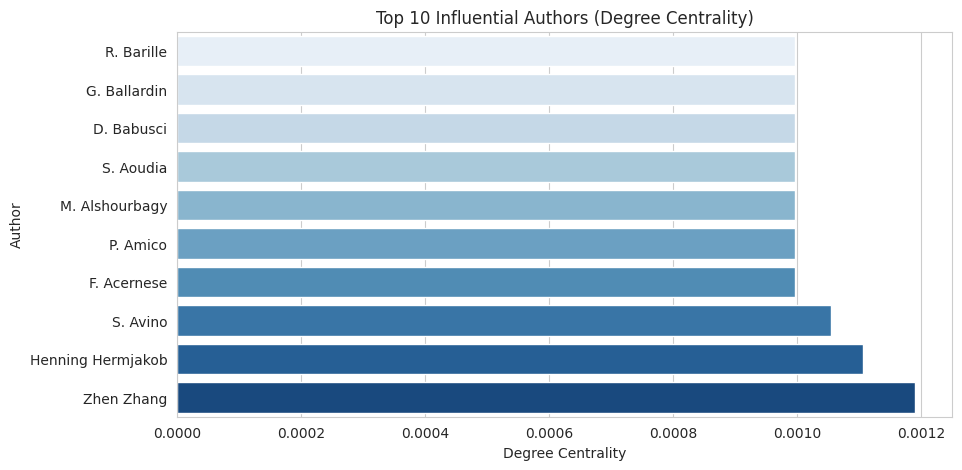

Top 5 Largest Author Communities:
Community 6: 1880 members
Community 38: 1531 members
Community 174: 1363 members
Community 77: 942 members
Community 46: 891 members


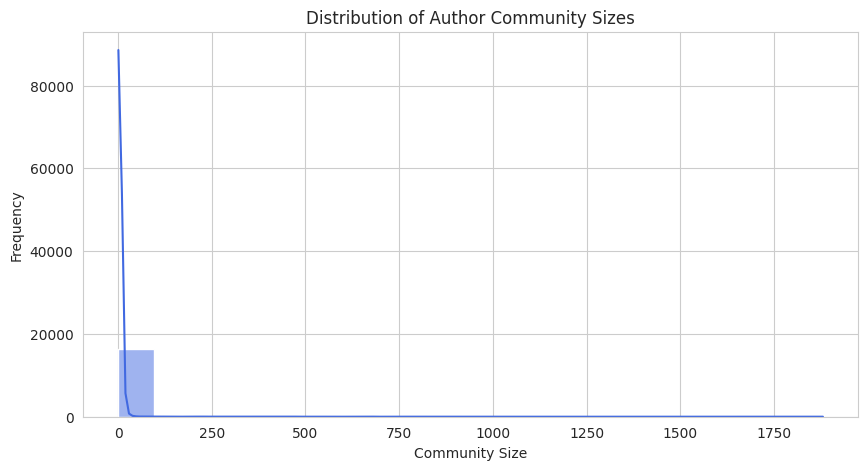

In [ ]:
from community import community_louvain

# Set theme and color palette
sns.set_style("whitegrid")
sns.set_palette("Blues")

# Load required columns for the co-authorship network
df = pd.read_csv(file_path, usecols=["authors", "year"])

# Sample a subset of data for performance efficiency
df = df.sample(frac=0.05, random_state=42)

# Convert 'authors' from string to list safely
df["authors"] = df["authors"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else []
)

# Create an undirected graph for co-authorship relationships
G = nx.Graph()

# Add edges based on co-authorship
for _, row in df.iterrows():
    authors = row["authors"]
    year = row["year"]
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            G.add_edge(authors[i], authors[j], year=year)

# 1. Compute Network Density Per Year
density_per_year = {}
for year in sorted(df["year"].unique()):
    edges_in_year = [(u, v) for u, v, d in G.edges(data=True) if d["year"] == year]
    G_sub = nx.Graph(edges_in_year)  # Subgraph for each year's collaborations
    density_per_year[year] = nx.density(G_sub)

# Plot Network Density Over Time
plt.figure(figsize=(10, 5))
sns.lineplot(x=list(density_per_year.keys()), y=list(density_per_year.values()), marker="o", color="steelblue")
plt.xlabel("Year")
plt.ylabel("Network Density")
plt.title("Co-Authorship Network Density Over Time")
plt.show()

# 2. Identify Influential Researchers Using Centrality Measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, normalized=True, endpoints=True, k=200)
closeness_centrality = nx.closeness_centrality(G, wf_improved=True)

# Extract Top 10 Authors for Each Centrality Measure
top_10_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Print Results
print("Top 10 Authors by Degree Centrality:", [x[0] for x in top_10_degree])
print("Top 10 Authors by Betweenness Centrality:", [x[0] for x in top_10_betweenness])
print("Top 10 Authors by Closeness Centrality:", [x[0] for x in top_10_closeness])

# Plot Top 10 Authors by Degree Centrality
plt.figure(figsize=(10, 5))
sns.barplot(
    x=[p[1] for p in top_10_degree],
    y=[p[0] for p in top_10_degree],
    palette="Blues_r"
)
plt.xlabel("Degree Centrality")
plt.ylabel("Author")
plt.title("Top 10 Influential Authors (Degree Centrality)")
plt.gca().invert_yaxis()
plt.show()

# 3. Community Detection in the Co-Authorship Network
partition = community_louvain.best_partition(G)  # Louvain method for detecting communities
community_sizes = Counter(partition.values())

# Print Top 5 Largest Communities
print("Top 5 Largest Author Communities:")
for community, size in community_sizes.most_common(5):
    print(f"Community {community}: {size} members")

# Plot Distribution of Community Sizes
plt.figure(figsize=(10, 5))
sns.histplot(list(community_sizes.values()), bins=20, kde=True, color="royalblue")
plt.xlabel("Community Size")
plt.ylabel("Frequency")
plt.title("Distribution of Author Community Sizes")
plt.show()


### 1.2.3 Venue Network (Conference-Journal Network):

#### **What We’ve Done**
1. Built a Conference-Journal (Venue) Citation Network
  - Constructed a directed graph where **nodes** represent venues (conferences or journals) and **edges** represent citation relationships between different venues.
  - Used a dictionary to efficiently map papers to their venues and built edges between citing and cited venues.

2. Analyzed Interdisciplinary Collaborations
  - Identified the **most frequent collaborations** between venues.
  - Visualized the **top 10 interdisciplinary collaborations** using a bar chart.

3. Found the Most Influential Venues
  - Measured **degree centrality**, **betweenness centrality**, and **PageRank** to rank influential venues.
  - Displayed the **top 10 most influential venues** based on PageRank using a bar chart.

4. Detected Emerging Fields
  - Tracked the number of new **venue connections per year** to analyze emerging research collaborations.
  - Plotted **new interdisciplinary collaborations over time** to observe research trends.


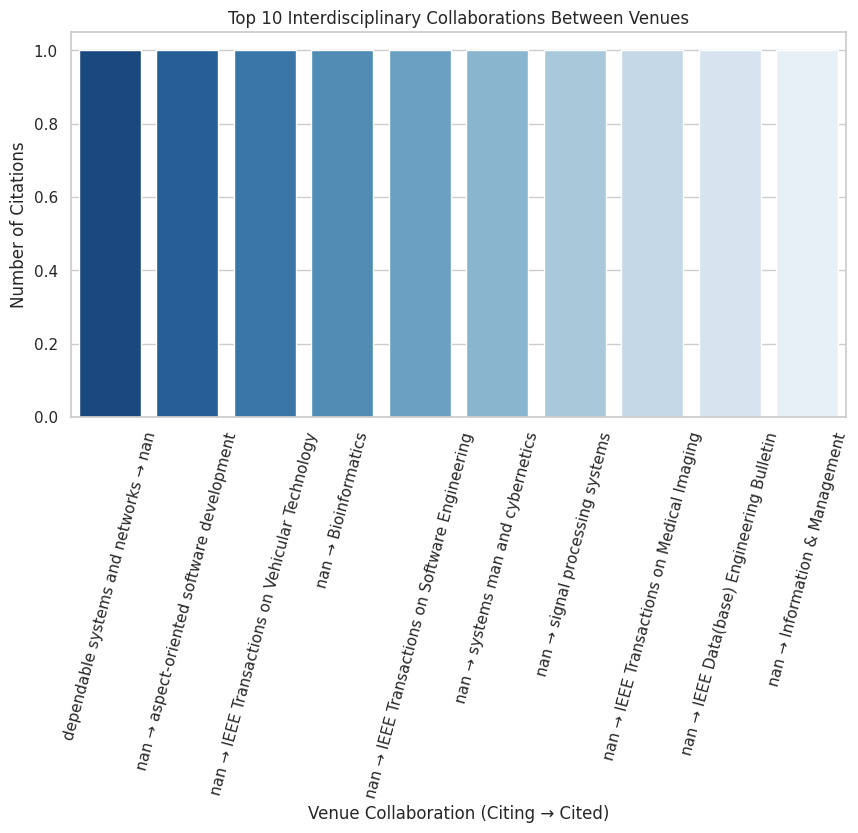

Top 10 Venues by Degree Centrality: [nan, 'IEEE Transactions on Communications', 'Journal of Machine Learning Research', 'Neural Computation', 'international conference on communications', 'IEEE Communications Letters', 'Bioinformatics', 'intelligent robots and systems', 'neural information processing systems', 'IEEE Transactions on Medical Imaging']
Top 10 Venues by Betweenness Centrality: [nan, 'IEEE Transactions on Communications', 'IEEE Communications Letters', 'design automation conference', 'international conference on communications', 'IEEE Transactions on Very Large Scale Integration Systems', 'empirical methods in natural language processing', 'international test conference', 'IEEE Transactions on Signal Processing', 'IEEE Transactions on Vehicular Technology']
Top 10 Venues by PageRank: ['Journal of Machine Learning Research', 'Journal of Artificial Intelligence Research', nan, 'IEEE Transactions on Pattern Analysis and Machine Intelligence', 'Neural Computation', 'IEEE Trans

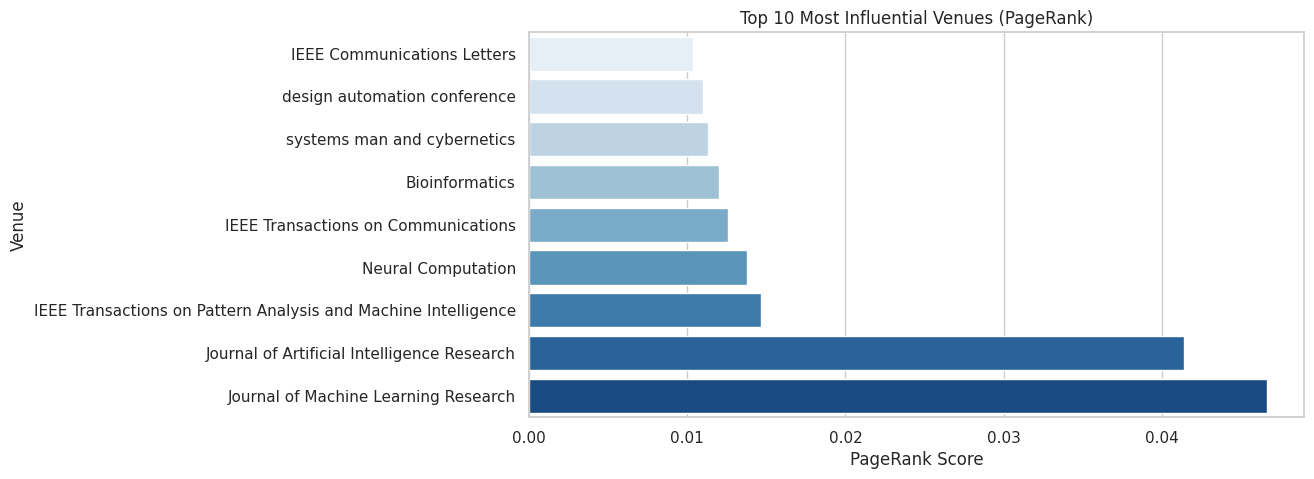

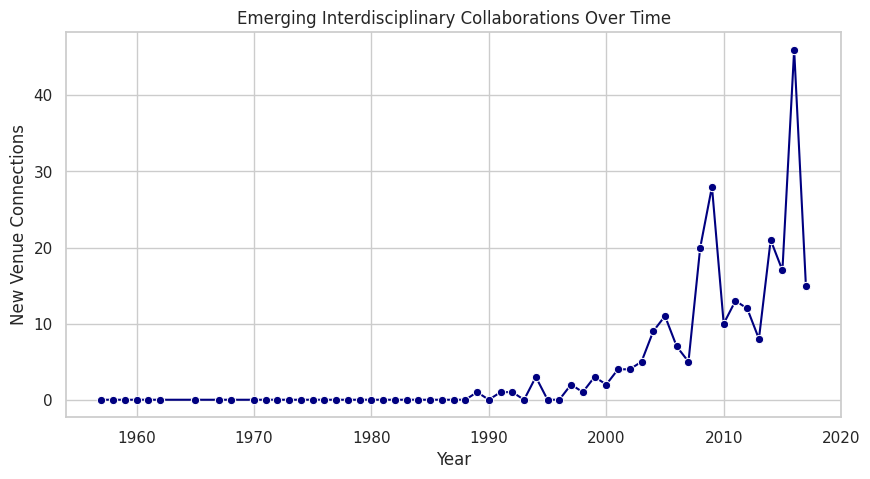

In [ ]:
# Set a consistent blue color theme for plots
sns.set_theme(style="whitegrid", palette="Blues")

# Load only the required columns for analysis
df = pd.read_csv(file_path, usecols=["venue", "references", "year", "id"])

# Sample a smaller subset for efficiency
df = df.sample(frac=0.01, random_state=42)

# Convert 'references' from string to list safely
df["references"] = df["references"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else []
)

# Create a directed graph for venue collaborations
G = nx.DiGraph()

# Dictionary to store venue information for each paper
venue_dict = {row["id"]: row["venue"] for _, row in df.iterrows()}

# Add edges where a paper cites another paper from a different venue
for _, row in df.iterrows():
    citing_venue = row["venue"]
    for ref_id in row["references"]:
        cited_venue = venue_dict.get(ref_id)
        if cited_venue and cited_venue != citing_venue:
            G.add_edge(citing_venue, cited_venue, year=row["year"])

# 1. Analyze Interdisciplinary Collaborations Between Venues
# Count (citing_venue → cited_venue) pairs
collaboration_counts = Counter((u, v) for u, v in G.edges())

# Extract the top 10 most frequent venue collaborations
top_10_collaborations = collaboration_counts.most_common(10)

# Ensure valid data before plotting
if top_10_collaborations:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=[f"{p[0][0]} → {p[0][1]}" for p in top_10_collaborations],  # Venue pairs
        y=[p[1] for p in top_10_collaborations],  # Citation counts
        palette="Blues_r"
    )
    plt.xticks(rotation=75)
    plt.xlabel("Venue Collaboration (Citing → Cited)")
    plt.ylabel("Number of Citations")
    plt.title("Top 10 Interdisciplinary Collaborations Between Venues")
    plt.show()
else:
    print("No collaborations found in the sampled dataset.")

# 2. Identify the Most Influential Venues Using Centrality Measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
pagerank_scores = nx.pagerank(G)

# Extract the top 10 venues for each centrality measure
top_10_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Venues by Degree Centrality:", [x[0] for x in top_10_degree])
print("Top 10 Venues by Betweenness Centrality:", [x[0] for x in top_10_betweenness])
print("Top 10 Venues by PageRank:", [x[0] for x in top_10_pagerank])

# Plot Top 10 Influential Venues by PageRank
plt.figure(figsize=(10, 5))
sns.barplot(
    x=[p[1] for p in top_10_pagerank],  # PageRank score
    y=[p[0] for p in top_10_pagerank],  # Venue names
    palette="Blues_r"
)
plt.xlabel("PageRank Score")
plt.ylabel("Venue")
plt.title("Top 10 Most Influential Venues (PageRank)")
plt.gca().invert_yaxis()
plt.show()

# 3. Detect Emerging Fields Based on Newly Formed Venue Connections
venue_connections_by_year = {
    year: sum(1 for _, _, d in G.edges(data=True) if d["year"] == year)
    for year in sorted(df["year"].unique())
}

# Ensure valid data before plotting
if venue_connections_by_year:
    plt.figure(figsize=(10, 5))
    sns.lineplot(
        x=list(venue_connections_by_year.keys()),
        y=list(venue_connections_by_year.values()),
        marker="o",
        color="navy"
    )
    plt.xlabel("Year")
    plt.ylabel("New Venue Connections")
    plt.title("Emerging Interdisciplinary Collaborations Over Time")
    plt.show()
else:
    print("No new venue connections found in the dataset.")


### 1.2.4. Temporal Evolution of the Citation Network:

#### **What We’ve Done**
1. Analyzed Citation Network Evolution Over Time
  - Constructed a **directed citation network** for different years to study how the structure changes.
  - Computed **network density per year** to track the growth of the citation network.
  - Visualized **network density over time** to observe long-term citation trends.

2. Identified Bursts of Influential Papers
  - Measured citation counts for each paper.
  - Defined **citation bursts** as papers in the **top 1% of citations received**.
  - Created a **histogram of bursts over time** to reveal when influential papers emerged.

3. Examined How New Papers Integrate Into the Citation Network
  - Tracked how many citations **newly published papers** received.
  - Calculated **average new connections per paper per year**.
  - Plotted **new paper integration over time** to understand how research builds upon past work.


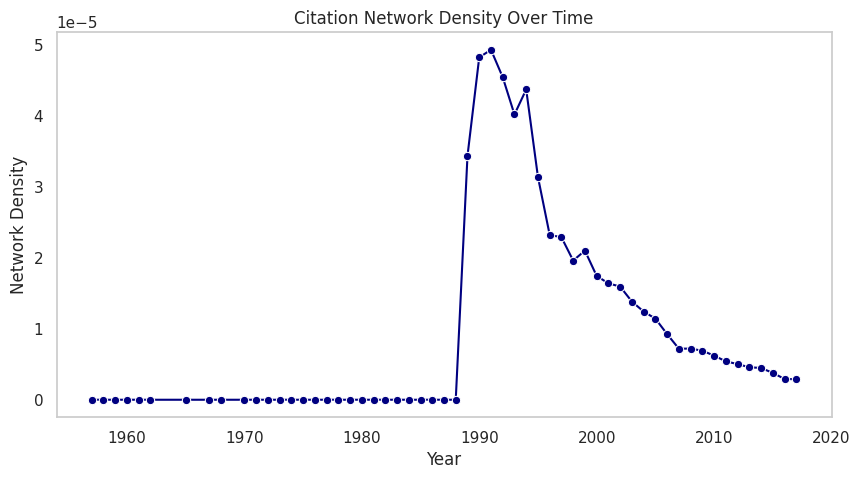

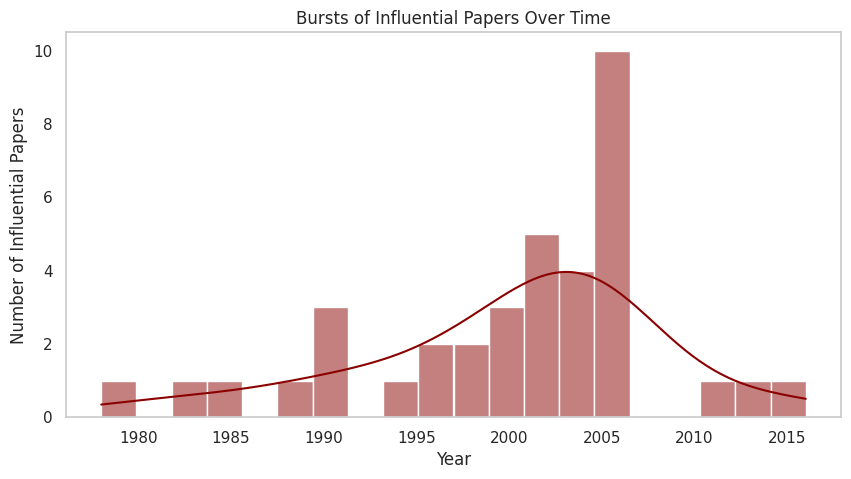

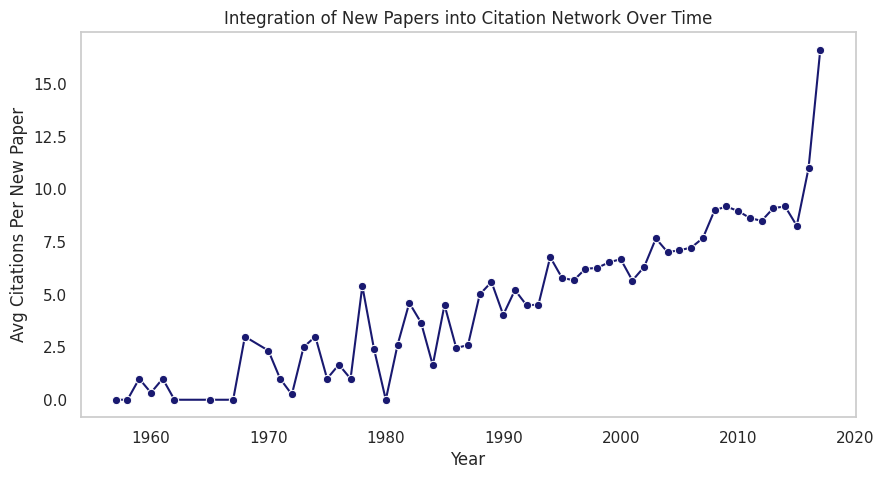

In [ ]:
# Set consistent blue color theme for plots
sns.set_theme(style="whitegrid", palette="Blues")

# Load only necessary columns to reduce memory usage
df = pd.read_csv(file_path, usecols=["id", "references", "year"])

# Sample a smaller subset for efficiency
df = df.sample(frac=0.01, random_state=42)

# Convert 'references' from string to list safely
df["references"] = df["references"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else []
)

# Get unique years in ascending order
years = sorted(df["year"].unique())

# 1. Network Density Per Year
network_density = {}

for year in years:
    G = nx.DiGraph()  # Directed citation graph

    # Consider papers published up to the given year
    df_year = df[df["year"] <= year]

    # Build citation network
    for _, row in df_year.iterrows():
        citing_paper = row["id"]
        G.add_node(citing_paper)  # Ensure paper node exists
        for ref_id in row["references"]:
            if ref_id in df_year["id"].values:  # Consider only references in dataset
                G.add_edge(ref_id, citing_paper)

    # Compute network density
    network_density[year] = nx.density(G) if len(G.nodes) > 1 else 0

# Plot Network Density Over Time
plt.figure(figsize=(10, 5))
sns.lineplot(
    x=list(network_density.keys()),
    y=list(network_density.values()),
    marker="o",
    color="navy"
)
plt.xlabel("Year")
plt.ylabel("Network Density")
plt.title("Citation Network Density Over Time")
plt.grid()
plt.show()

# 2. Detect Bursts of Influential Papers
citation_counts = Counter()

# Count how many times each paper is cited
for _, row in df.iterrows():
    for ref in row["references"]:
        citation_counts[ref] += 1

# Map citation counts to the original dataset
df["citations_received"] = df["id"].map(citation_counts)

# Identify papers with sudden citation bursts (top 1%)
top_burst_papers = df[df["citations_received"] > df["citations_received"].quantile(0.99)]

# Plot bursts of influential papers over time
plt.figure(figsize=(10, 5))
sns.histplot(
    top_burst_papers["year"],
    bins=20,
    kde=True,
    color="darkred"
)
plt.xlabel("Year")
plt.ylabel("Number of Influential Papers")
plt.title("Bursts of Influential Papers Over Time")
plt.grid()
plt.show()

# 3. How New Papers Integrate into the Network
integration_per_year = {}

for year in years:
    df_year = df[df["year"] == year]
    total_new_citations = sum(len(row["references"]) for _, row in df_year.iterrows())
    integration_per_year[year] = total_new_citations / len(df_year) if len(df_year) > 0 else 0  # Avg citations per new paper

# Plot integration of new papers over time
plt.figure(figsize=(10, 5))
sns.lineplot(
    x=list(integration_per_year.keys()),
    y=list(integration_per_year.values()),
    marker="o",
    color="midnightblue"
)
plt.xlabel("Year")
plt.ylabel("Avg Citations Per New Paper")
plt.title("Integration of New Papers into Citation Network Over Time")
plt.grid()
plt.show()


# 2 Data Extrapolation via Clustering:

## 2.1-2 Community Detection, Naming the Communities:


In [ ]:
!pip install keybert

### **Community Detection**  

In this section, we constructed an **author collaboration network** and identified research communities using three clustering algorithms: **hierarchical clustering, spectral clustering, and Louvain clustering**. To improve efficiency, we first trained and evaluated these methods on a **random subset (0.001%) of the dataset**, selecting the best-performing algorithm based on the **silhouette score**. We then applied the selected algorithm to the **entire dataset** to form final author communities. Finally, we extracted **keywords** from research papers to provide meaningful names for each detected research community.  

#### **Building the Author Collaboration Network**  
We first loaded the dataset and extracted relevant columns, including **author names, paper titles, abstracts, and venues**. To reduce computation time, we sampled **N% of the dataset** for initial training and evaluation.  

Next, we **constructed a co-authorship network**, where:  
- **Nodes** represent authors.  
- **Edges** are formed between co-authors.  
- **Edge weights** increase based on the number of shared papers between two authors.  
- Each author retains metadata linking them to the **papers they have contributed to**.  

The network was then converted into an **adjacency matrix**, which served as the input for our clustering algorithms.  

#### **Clustering the Author Network**  
To detect research communities within the author network, we trained and compared three clustering methods:  

1. **Hierarchical Clustering**  
   - We computed a hierarchical linkage matrix using the **average linkage** method.  
   - A dendrogram was generated to visualize the clustering structure.  

2. **Spectral Clustering**  
   - We applied **spectral clustering** using a graph affinity matrix, specifying five clusters.  

3. **Louvain Clustering**  
   - We used the **Louvain method**, which optimizes modularity for **network-based community detection**.  

#### **Evaluating the Clustering Algorithms**  
To determine the most effective clustering algorithm, we **calculated the silhouette score** for all three methods. This metric evaluates how well data points are assigned to clusters by comparing intra-cluster similarity to inter-cluster differences.  

After computing the silhouette scores for **hierarchical, spectral, and Louvain clustering**, we **selected the best-performing algorithm** and visualized the results using a **bar plot**.  

#### **Training the Best Clustering Algorithm on the Full Dataset**  
Once we identified the best clustering method, we **retrained it on the full dataset** to capture a more comprehensive structure of the author network. This ensured that the final detected research communities were based on all available data.  

#### **Naming the Communities Using Keywords**  
To assign **descriptive labels** to each community, we extracted **keywords** from the research paper titles and abstracts using the **KeyBERT library**. The process included:  
- Associating each **paper** with the corresponding **community of its authors**.  
- Aggregating **keywords from all papers** within a community.  
- Identifying the **most frequently occurring keywords** to represent each research community.  

These top keywords provided meaningful insights into the **thematic focus** of each community, allowing us to generate **descriptive names** for the research groups.  

This approach allowed us to not only **detect groups of researchers working on similar topics** but also **interpret and label each research community** in a meaningful way.

In [ ]:
# Load Data
df = pd.read_csv(file_path, usecols=["id", "authors", "title", "abstract", "venue"])

# Convert 'authors' from string to list
df["authors"] = df["authors"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else []
)

# Sample N% of the dataset
N_PERCENT = 0.001
df_sample = df.sample(frac=N_PERCENT, random_state=42)

# Function to Build Author Collaboration Network
def build_author_graph(data):
    G = nx.Graph()
    for _, row in data.iterrows():
        authors = row["authors"]
        for a1, a2 in combinations(authors, 2):
            if G.has_edge(a1, a2):
                G[a1][a2]["weight"] += 1
            else:
                G.add_edge(a1, a2, weight=1)

    # Store papers per author
    author_papers = data.explode("authors").groupby("authors")["id"].apply(list).to_dict()
    nx.set_node_attributes(G, author_papers, "papers")
    return G

# Construct Graph and Adjacency Matrix
G_sample = build_author_graph(df_sample)
nodes_sample = list(G_sample.nodes)
adj_matrix_sample = nx.to_numpy_array(G_sample, nodelist=nodes_sample)


Best clustering method: Louvain (Silhouette Score: 0.3795)


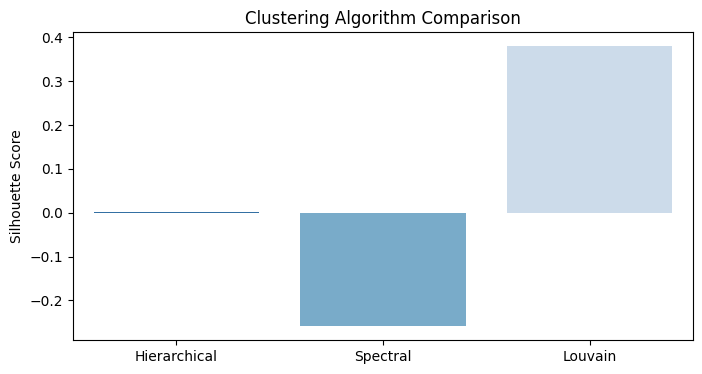

In [ ]:
# Define Clustering Methods
def hierarchical_clustering(adj_matrix, nodes):
    Z = linkage(adj_matrix, method="average")
    labels = fcluster(Z, 1.0, criterion="distance")
    return [labels[i] for i in range(len(nodes))]

def spectral_clustering(adj_matrix, n_clusters=5):
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    return clustering.fit_predict(adj_matrix)

def louvain_clustering(G):
    partition = community_louvain.best_partition(G)
    return [partition.get(node, -1) for node in G.nodes()]

# Run Clustering
labels_hierarchical = hierarchical_clustering(adj_matrix_sample, nodes_sample)
labels_spectral = spectral_clustering(adj_matrix_sample)
labels_louvain = louvain_clustering(G_sample)

# Evaluate using Silhouette Score
def evaluate_clustering(adj_matrix, labels):
    condensed_matrix = squareform(pdist(adj_matrix))
    return silhouette_score(condensed_matrix, labels, metric="euclidean")

scores = {
    "Hierarchical": evaluate_clustering(adj_matrix_sample, labels_hierarchical),
    "Spectral": evaluate_clustering(adj_matrix_sample, labels_spectral),
    "Louvain": evaluate_clustering(adj_matrix_sample, labels_louvain),
}

# Select Best Algorithm
best_algo = max(scores, key=scores.get)
print(f"Best clustering method: {best_algo} (Silhouette Score: {scores[best_algo]:.4f})")

# Plot Silhouette Scores
plt.figure(figsize=(8, 4))
sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette="Blues_r")
plt.ylabel("Silhouette Score")
plt.title("Clustering Algorithm Comparison")
plt.show()


In [ ]:
# Sample 0.001 of the full dataset for efficiency
df_sampled = df.sample(frac=0.001, random_state=42)

# Build Author Collaboration Graph
G_sampled = build_author_graph(df_sampled)
nodes_sampled = list(G_sampled.nodes)
adj_matrix_sampled = nx.to_numpy_array(G_sampled, nodelist=nodes_sampled)

# Apply Best Clustering Algorithm
# if best_algo == "Hierarchical":
#     best_labels = hierarchical_clustering(adj_matrix_sampled, nodes_sampled)
# elif best_algo == "Spectral":
#     best_labels = spectral_clustering(adj_matrix_sampled)
# else:
best_labels = louvain_clustering(G_sampled)

# Assign Communities to Authors
author_community = {author: best_labels[i] for i, author in enumerate(nodes_sampled)}

# Associate Papers with Communities
paper_communities = {}
for author, papers in nx.get_node_attributes(G_sampled, "papers").items():
    community = author_community.get(author, -1)
    for paper in papers:
        paper_communities.setdefault(paper, set()).add(community)

# Extract Keywords using KeyBERT
kw_model = KeyBERT()
df_sampled["keywords"] = df_sampled.apply(
    lambda row: kw_model.extract_keywords(f"{row['title']} {row['abstract']}",
                                          keyphrase_ngram_range=(1, 2),
                                          stop_words="english"),
    axis=1,
)

# Aggregate Keywords per Community
community_keywords = {c: [] for c in set(best_labels)}
for paper, communities in paper_communities.items():
    keywords = df_sampled.loc[df_sampled["id"] == paper, "keywords"].values
    if len(keywords) > 0:
        for community in communities:
            if community != -1:
                community_keywords[community].extend([kw[0] for kw in keywords[0]])

# Determine Top Keywords for Community Naming
top_keywords_per_community = {
    c: [kw for kw, _ in Counter(kw_list).most_common(3)] for c, kw_list in community_keywords.items()
}

# Assign Meaningful Names
community_names = {c: " ".join(top_keywords_per_community[c]) for c in top_keywords_per_community}

# Print Community Names
for community, keywords in community_names.items():
    print(f"Community {community}: {keywords}")


Community 0: parallelization hevc hevc encoding alternative hevc
Community 1: concurrency isolation concurrency storage engine
Community 2: camera fpga position camera orientation camera
Community 3: visual tracking bayesian filtering multiple cameras
Community 4: crowdsourcing services crowdsourcing service crowdsourcing development
Community 5: microscopy deconvolution deconvolution algorithm microscopy restoration
Community 6: features weighted weighted feature minimization logistic
Community 7: speech reconstruction auditory cortex human auditory
Community 8: infection dynamics measuring outbreak risk water
Community 9: instruction learning long jump assisted instruction
Community 10: scheduling framework adaptive scheduling scheduling schemes
Community 11: networks manet reputation mobile hoc networks
Community 12: facebook use relationship facebook facebook
Community 13: applications slam slam implementation mapping slam
Community 14: distributed video video objects controlling b

## 2.3 Paper-Paper Clustering via Embedding:

### Paper-Paper Clustering via Embedding  

In this section, we clustered research papers based on their textual content and community-related keywords. We used sentence embeddings to represent each paper, applied clustering techniques to group similar papers, and evaluated the clustering results using established metrics.  

#### Embedding the Abstracts and Titles  

To create meaningful numerical representations of research papers, we embedded their abstracts and titles using a pre-trained Sentence Transformer model. We enhanced the embeddings by appending community-specific keywords extracted earlier, ensuring that the embedding captured both the paper's content and its associated research community.  

We used a sampled subset of the dataset to improve computational efficiency while maintaining a representative selection of research papers. The dataset contained paper identifiers, author information, titles, abstracts, and venues. We preprocessed the data by combining each paper's title, abstract, and associated community keywords into a single text representation.  

#### Clustering Papers  

After obtaining the text embeddings, we applied the K-Means clustering algorithm to group papers into five clusters. This approach allowed us to identify sets of research papers that shared thematic similarities. The choice of five clusters was based on empirical testing and domain relevance.  

#### Evaluating the Clustering Algorithm  

To assess the quality of the clustering, we computed the Davies-Bouldin Index and the Silhouette Score. The Davies-Bouldin Index evaluates the compactness and separation of clusters, with lower values indicating better clustering performance. The Silhouette Score measures how similar each paper is to its assigned cluster compared to other clusters, with higher values indicating better-defined clusters. These metrics provided insights into the effectiveness of the clustering approach.  

#### Venue-Based Analysis and Jaccard Similarity  

To further evaluate the clustering results, we analyzed the unique venues present in the dataset. Since the venue of a research paper often reflects its subject area, we compared our generated clusters with venue-based groupings. We used the Jaccard Similarity Index to measure the overlap between the clustering results and venue-based labels. This metric quantified how well the discovered clusters aligned with venue categorizations, serving as an additional validation step.  

By embedding paper content, incorporating community-related keywords, applying clustering, and evaluating the results with multiple metrics, we effectively grouped research papers based on their thematic similarities while optimizing computational resources.

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, jaccard_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Add Community Keywords to Each Paper
def get_community_keywords(paper_id):
    """Retrieve keywords from all communities a paper belongs to."""
    communities = paper_communities.get(paper_id, [])
    keywords = set()
    for community in communities:
        keywords.update(community_keywords.get(community, []))
    return " ".join(keywords)

df_sampled["community_keywords"] = df_sampled["id"].apply(get_community_keywords)

# Embedding Abstracts & Titles
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Combine title, abstract, and community keywords for embedding
df_sampled["combined_text"] = df_sampled.apply(
    lambda row: f"{row['title']} {row['abstract']} {row['community_keywords']}", axis=1
)

# Generate embeddings
embeddings = embedder.encode(df_sampled["combined_text"].tolist())

# Clustering Papers
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
paper_labels = kmeans.fit_predict(embeddings)

# Evaluation
dbi_score = davies_bouldin_score(embeddings, paper_labels)
sil_score = silhouette_score(embeddings, paper_labels)

print(f"Davies-Bouldin Index: {dbi_score:.4f}")
print(f"Average Silhouette Score: {sil_score:.4f}")

# Unique Venue Values
if "venue" in df_sampled.columns:
    unique_venues = df_sampled["venue"].unique()
    print(f"Unique venues: {unique_venues}")
else:
    print("Venue column not found in the dataset.")

# Jaccard Similarity with Venue Clustering
if "venue" in df_sampled.columns:
    le = LabelEncoder()
    venue_labels = le.fit_transform(df_sampled["venue"])

    min_len = min(len(venue_labels), len(paper_labels))
    jaccard_sim = jaccard_score(
        venue_labels[:min_len], paper_labels[:min_len], average="macro"
    )
    print(f"Jaccard Similarity Index with venue clustering: {jaccard_sim}")
else:
    print("Jaccard Similarity not computed as 'venue' column is missing.")


Davies-Bouldin Index: 4.5553
Average Silhouette Score: 0.0362
Unique venues: ['multimedia signal processing'
 'international conference on enterprise information systems'
 'Journal of Systems Architecture'
 'Journal of Machine Vision and Applications' nan
 'international conference on pattern recognition'
 'Medical Image Analysis'
 'conference of the international speech communication association'
 'Management Science'
 'international conference for young computer scientists'
 'Journal of Computer-Mediated Communication'
 'IEEE Transactions on Multimedia' 'Lecture Notes in Computer Science'
 'Spring'
 'international conference on frontiers in handwriting recognition'
 'international conference on robotics and automation'
 'Computers & Industrial Engineering' 'arXiv: Information Retrieval'
 'cooperative information systems' 'ubiquitous computing'
 'advances in social networks analysis and mining'
 'congress on evolutionary computation'
 'Journal of the Operational Research Society'
 'in

# 3 Citation Regressor:

###  What We've Done:
1. **Data Loading & Preprocessing**:
   - Loaded a subset of the dataset for efficient training.
   - Removed missing values.
   - Combined titles and abstracts to create a more informative text representation.

2. **Text Embeddings**:
   - Used **SentenceTransformer (paraphrase-MiniLM-L6-v2)** to convert text into numerical embeddings.

3. **Model Training**:
   - Split data into **train (80%) and validation (20%)**.
   - Used **Random Forest Regressor** and performed **GridSearchCV** for hyperparameter tuning.

4. **Validation Metrics**:
   - Evaluated the model using **RMSE, MAE, and R² score**.

5. **Test Data Processing**:
   - Loaded additional test data from multiple **JSON files**.
   - Preprocessed and embedded the test data.

6. **Final Evaluation on Test Set**:
   - Predicted citation counts and calculated key regression metrics.



In [ ]:
import pandas as pd
import numpy as np
import re
import json
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

# Load dataset
file_path = "dblp-v10.csv"
df = pd.read_csv(file_path, usecols=["id", "title", "abstract", "n_citation"])

# Sample a small subset for faster training (adjust as needed)
df = df.sample(frac=0.005, random_state=42)

# Drop missing values
df.dropna(subset=["title", "abstract", "n_citation"], inplace=True)

# Combine title and abstract for better text representation
df["text"] = df["title"] + " " + df["abstract"]

# Initialize SentenceTransformer for text embeddings
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Generate text embeddings
embeddings = model.encode(df["text"].tolist(), show_progress_bar=True)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    embeddings, df["n_citation"].values, test_size=0.2, random_state=42
)


Batches:   0%|          | 0/130 [00:00<?, ?it/s]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10, 20],
    "min_samples_split": [5, 10]
}

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perform GridSearch to find the best model
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_rf = grid_search.best_estimator_


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on validation data
y_pred = best_rf.predict(X_val)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation R²: {r2:.4f}")


Validation RMSE: 126.11
Validation MAE: 45.91
Validation R²: -0.1504


In [ ]:
# Define test dataset location
topics = ["Foundation_Models", "Generative_Models", "LLM", "VLM", "Diffusion_Models"]
folder_path = "/content"  # Update this to the correct directory

# Load all test data from JSON files
test_papers = []
for topic in topics:
    file_path = f"{folder_path}/{topic}_data.json"
    with open(file_path, "r") as f:
        data = json.load(f)
        for item in data:
            test_papers.extend(item.get("papers", []))

# Preprocessing function for test data
def preprocess_text(text):
    if text is None:
        return ""  # Handle missing abstracts
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# Apply preprocessing to test papers
test_texts = [
    preprocess_text((paper.get("title") or "") + " " + (paper.get("abstract") or ""))
    for paper in test_papers
]

# Generate embeddings for test data
X_test = model.encode(test_texts)

In [ ]:
# Get actual citation counts (assuming available in test data)
y_true = [paper.get("citations", 0) for paper in test_papers]

# Predict citation counts
y_pred = best_rf.predict(X_test)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print evaluation results
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

Test RMSE: 643.2402
Test MAE: 125.3138
Test R²: -0.0285
